<a href="https://colab.research.google.com/github/shubz2911/DSA-Java/blob/main/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

!cp "/content/drive/MyDrive/Colab Notebooks/FamilyDataset.zip" /content/
!unzip -q "/content/FamilyDataset.zip" -d /content/



replace /content/FamilyDataset/Sachin/BBB_4299.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/FamilyDataset/Sachin/BBB_4300.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: yA
replace /content/FamilyDataset/Sachin/BBB_4301.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [6]:
!pip install tensorflow opencv-python matplotlib


In [7]:
!pip install -q albumentations opencv-python


In [8]:
import pandas
print(pandas.__version__)
print(pandas.__file__)




2.2.2
/usr/local/lib/python3.12/dist-packages/pandas/__init__.py


In [5]:
!pip install mtcnn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.5 MB/s eta 0:00:00


In [8]:
!pip install lz4
# reinstall lz4 and joblib so that joblib detects lz4 correctly
!pip install --upgrade --force-reinstall lz4 joblib


  Using cached lz4-4.4.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
Using cached lz4-4.4.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: lz4
    Found existing installation: lz4 4.4.4
    Uninstalling lz4-4.4.4:
      Successfully uninstalled lz4-4.4.4
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.2
    Uninstalling joblib-1.5.2:
      Successfully uninstalled joblib-1.5.2


In [20]:
import albumentations
print(albumentations.__version__)


2.0.8


In [22]:
import os, cv2
from albumentations import Compose, RandomBrightnessContrast, HueSaturationValue

input_root  = '/content/FamilyDataset'
output_root = '/content/ProcessedFamilyDataset'
os.makedirs(output_root, exist_ok=True)

transform = Compose([
    RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.9),
    HueSaturationValue(hue_shift_limit=15, sat_shift_limit=20, val_shift_limit=15, p=0.9)
])

count = 0
for root, dirs, files in os.walk(input_root):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')):
            in_path  = os.path.join(root, file)
            rel_path = os.path.relpath(root, input_root)
            out_dir  = os.path.join(output_root, rel_path)
            os.makedirs(out_dir, exist_ok=True)

            img = cv2.imread(in_path)
            if img is None:
                print("⚠️  Could not read:", in_path)
                continue

            name, ext = os.path.splitext(file)
            for i in range(3):
                aug = transform(image=img)["image"]
                out_path = os.path.join(out_dir, f"{name}_aug{i}{ext}")
                cv2.imwrite(out_path, aug)
                count += 1
print(f"✅ Done. Created {count} augmented images.")


✅ Done. Created 717 augmented images.


In [9]:
#import cv2, os, glob      DON'T RUN
from mtcnn import MTCNN

input_root  = "/content/FamilyDataset"           # original images
output_root = "/content/ProcessedFamilyDataset"  # new, cleaned dataset
os.makedirs(output_root, exist_ok=True)

detector = MTCNN()

for person in os.listdir(input_root):
    in_dir  = os.path.join(input_root, person)
    out_dir = os.path.join(output_root, person)
    os.makedirs(out_dir, exist_ok=True)

    for img_path in glob.glob(os.path.join(in_dir, "*.jpg")):
        img = cv2.imread(img_path)
        if img is None:    # skip unreadable files
            continue
        faces = detector.detect_faces(img)
        if not faces:
            continue
        x, y, w, h = faces[0]['box']      # first detected face
        x, y = max(x,0), max(y,0)         # avoid negatives
        face_crop = img[y:y+h, x:x+w]
        face_resized = cv2.resize(face_crop, (224, 224))
        out_path = os.path.join(out_dir, os.path.basename(img_path))
        cv2.imwrite(out_path, face_resized)


In [23]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ✅ FIXED import:
from tensorflow.keras.applications import MobileNetV3Small, mobilenet_v3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

data_dir = "/content/ProcessedFamilyDataset"

# ---------- Preprocessing + Data Gen ----------
# Use the preprocessing function from mobilenet_v3
preprocess_layer = layers.Lambda(mobilenet_v3.preprocess_input)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1)
])


datagen = ImageDataGenerator(validation_split=0.2)

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    seed=42
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    seed=42
)

# ---------- Base Model ----------
base = MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False   # freeze for first stage

# ---------- Model Architecture ----------
inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_layer(x)
x = base(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(train_data.num_classes, activation="softmax")(x)
model = Model(inputs, outputs)

# ---------- Compile + Training Strategy ----------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)
]

# Stage 1
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=callbacks
)

# ---------- Fine-tune ----------
base.trainable = True
for layer in base.layers[:-10]:
    layer.trainable = False  # unfreeze only last 20 layers

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks
)

os.makedirs("/content/drive/MyDrive", exist_ok=True)
model.save("/content/drive/MyDrive/family_detector.keras")
print("✅ Model saved in native Keras format")


Found 956 images belonging to 2 classes.
Found 239 images belonging to 2 classes.
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5260 - loss: 0.8492 - val_accuracy: 0.4477 - val_loss: 0.7935 - learning_rate: 0.0010
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6803 - loss: 0.5808 - val_accuracy: 0.5732 - val_loss: 0.7106 - learning_rate: 0.0010
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 941ms/step - accuracy: 0.7566 - loss: 0.4766 - val_accuracy: 0.6402 - val_loss: 0.5970 - learning_rate: 0.0010
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 972ms/step - accuracy: 0.8283 - loss: 0.3962 - val_accuracy: 0.6820 - val_loss: 0.5467 - learning_rate: 0.0010
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 958ms/step - accuracy: 0.8108 - loss: 0.3912 - val_accuracy: 0.6946 - val_loss: 0.5211 - learning_rate: 0.0010
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 922ms/step - accuracy: 0.8509 - loss: 0.3555 - val_accuracy: 0.6904 - val_loss: 0.5214 - learning_rate: 0.0010
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 955ms/step - accuracy: 0.8705 - loss: 0.3087 -

In [ ]:
!rm -rf "/content/FamilyDataset/.ipynb_checkpoints"
!ls -a /content/FamilyDataset



.  ..  Other  Sachin  Shubham


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted: Shubham


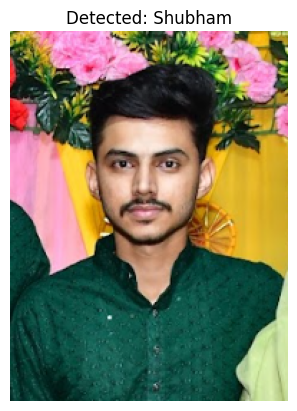

In [27]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

labels = sorted(os.listdir(data_dir))
img_path = "/content/FamilyDataset/Shubham/Screenshot 2025-09-13 092227.png"  # change to your test image path

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
print("Predicted:", labels[np.argmax(pred)])

plt.imshow(image.load_img(img_path))
plt.title(f"Detected: {labels[np.argmax(pred)]}")
plt.axis("off")
plt.show()
